In [12]:
# !pip install pandas
# !pip install numpy
# !pip install cryptocompare
# !pip install hurst
# !pip install ccxt
# !pip install tqdm
# !pip install requests
# !pip install matplotlib

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm.notebook import tqdm

from hurst import compute_Hc

from backtest_instruments.utils import get_tickers, get_prices, plot_prices

In [2]:
# Gets all tickers that are traded on binance

tickers_tmp = get_tickers()
tickers = []
for ticker in tickers_tmp:
    if ticker[-4:] == 'USDT': # Only USDT pairs
        tickers.append(ticker)

In [3]:
# Calculate crypto statistics in order to pre-select tickers for bot-strategies

def get_annualized_volatility(df):
    df['returns'] = df['close'].pct_change()
    volatility = df['returns'].std() * np.sqrt(252)
    return volatility

def get_trendlessness_factor(df):
    _, H, _ = compute_Hc(df['close'], kind='price', simplified=True)
    return H

ticker_stats = []
for ticker in tqdm(tickers):

    prices = get_prices(ticker, interval='1d', limit=1000)
    if prices.shape[0] < 900:
        continue
    volatility = get_annualized_volatility(prices)
    trendlessness = get_trendlessness_factor(prices)
    ticker_stats.append({'ticker': ticker, 'volatility': volatility, 'trendlessness': trendlessness})

ticker_stats = pd.DataFrame(ticker_stats)

  0%|          | 0/524 [00:00<?, ?it/s]

In [4]:
# ticker_stats.to_csv('data/ticker_stats')
# ticker_stats = pd.read_csv('data/ticker_stats')
ticker_stats.head()

,ticker,volatility,trendlessness
0,PAXUSDT,0.031928,1.031814
1,WAVESUSDT,1.044147,0.248093
2,BTTUSDT,1.178092,0.283444
3,XMRUSDT,0.651022,1.146591
4,NANOUSDT,1.309328,0.405844


# Reality check

Here I check that all functions and calculated statistics work according to common sense

## Low volotility 

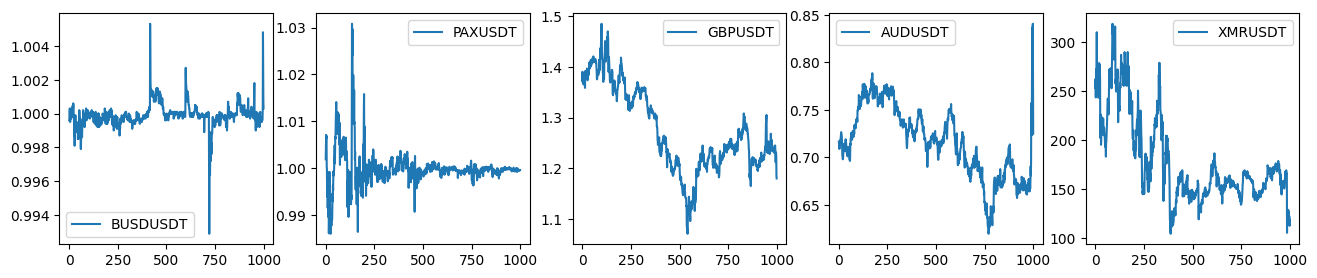

In [5]:
top_tickers = ticker_stats.sort_values('volatility', ascending=True)
top_tickers = top_tickers.head(5)['ticker'].to_numpy()
plot_prices(top_tickers)

## Low trendlessness

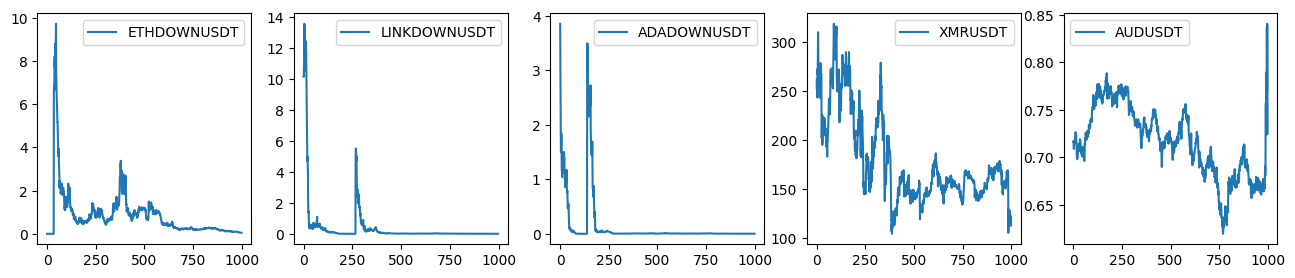

In [6]:
top_tickers = ticker_stats.sort_values('trendlessness', ascending=False).head(5)
top_tickers = top_tickers.sort_values('volatility', ascending=False)['ticker'].to_numpy()
plot_prices(top_tickers)

# 

In [ ]:
# Based on heuristics I preselected the following tickers
tickers = ['PAXUSDT', 'XMRUSDT', 'BUSDUSDT']

# Download this tickers
for ticker in tickers:
    tmp_data = get_prices(ticker, interval='1d', limit=1000)
    if tmp_data is None: # Some tickers may not be available on binance
        continue
    tmp_data.to_csv(f'data/{ticker}.csv')